<a href="https://colab.research.google.com/github/iamharkirat/Machine-Learning-Projects/blob/main/EGR598_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [21]:
df=pd.read_csv('/content/drive/MyDrive/data_egr598/data.csv')
df.head()

,timestamp,image_path,linear_x,angular_z
0,1.681869e+09,data/1681868895.429364.png,0.0,0.0
1,1.681869e+09,data/1681868895.476021.png,0.0,0.0
2,1.681869e+09,data/1681868895.517218.png,0.0,0.0
3,1.681869e+09,data/1681868895.581254.png,0.0,0.0
4,1.681869e+09,data/1681868895.626300.png,0.0,0.0


In [22]:
# Remove the 'data/' prefix from the image_path column
df['image_path'] = df['image_path'].str.replace('data/', '')

# Add the '/content/drive/MyDrive/data_egr598/' prefix to the image_path column
df['image_path'] = '/content/drive/MyDrive/data_egr598/' + df['image_path'].str.replace('.png', '.png')

# Show the updated DataFrame
df.head()

<ipython-input-22-2cc0ddd02302>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df['image_path'] = '/content/drive/MyDrive/data_egr598/' + df['image_path'].str.replace('.png', '.png')


,timestamp,image_path,linear_x,angular_z
0,1.681869e+09,/content/drive/MyDrive/data_egr598/1681868895....,0.0,0.0
1,1.681869e+09,/content/drive/MyDrive/data_egr598/1681868895....,0.0,0.0
2,1.681869e+09,/content/drive/MyDrive/data_egr598/1681868895....,0.0,0.0
3,1.681869e+09,/content/drive/MyDrive/data_egr598/1681868895....,0.0,0.0
4,1.681869e+09,/content/drive/MyDrive/data_egr598/1681868895....,0.0,0.0


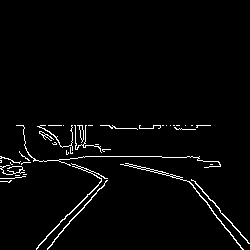

In [41]:
import cv2
import numpy as np
from PIL import Image

# Open the image file
img = Image.open('/content/drive/MyDrive/data_egr598/1681868895.429364.png')

# Convert the image to grayscale
gray = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)

# Create a mask to select only the lower half of the image
mask = np.zeros_like(gray)
mask[int(mask.shape[0] / 2):, :] = 255

# Apply the Canny filter to the masked image
canny = cv2.Canny(cv2.bitwise_and(gray, gray, mask=mask), 100, 200)

# Set the upper half of the image to black
canny[:int(mask.shape[0] / 2), :] = 0

# Convert the filtered image back to PIL Image and show it
canny_img = Image.fromarray(canny)
canny_img.show()

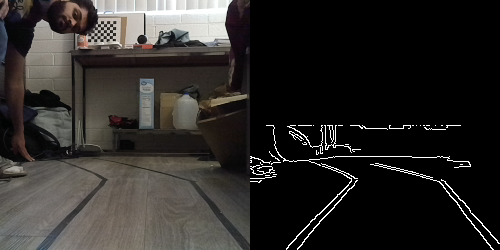

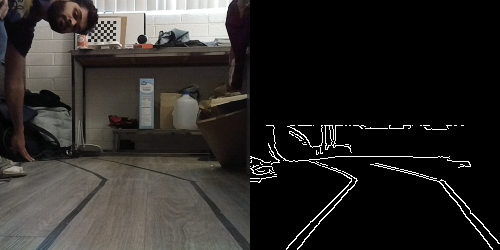

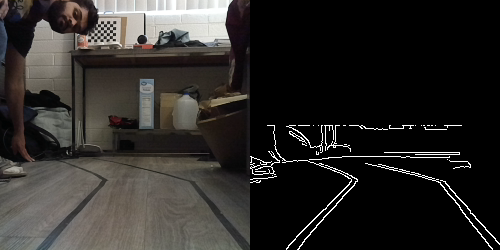

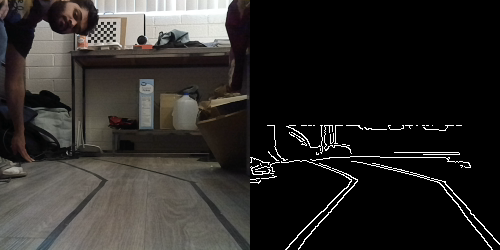

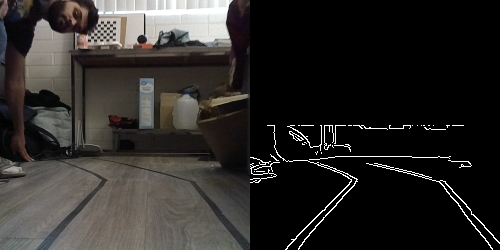

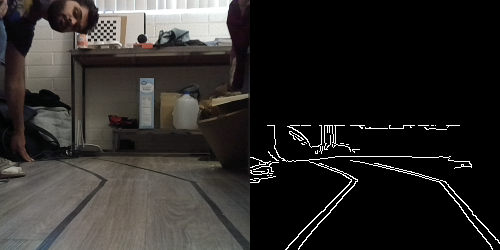

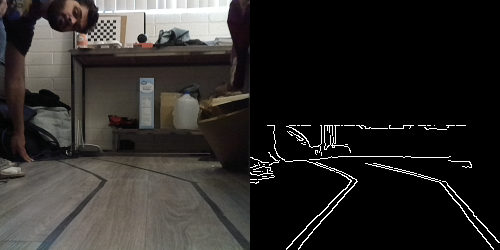

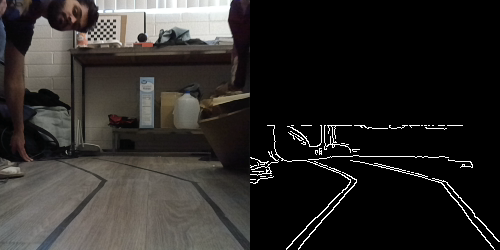

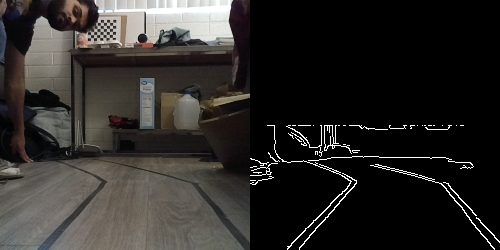

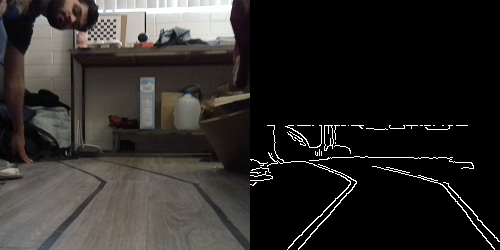

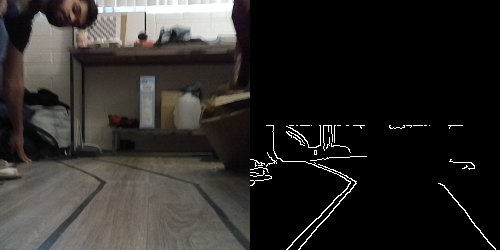

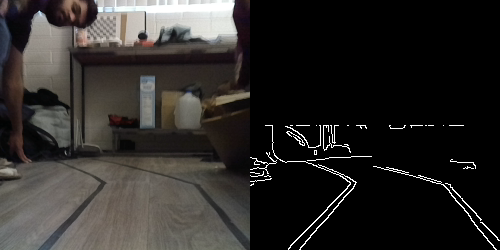

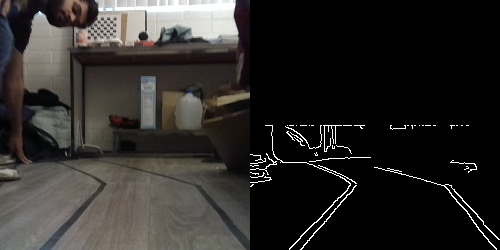

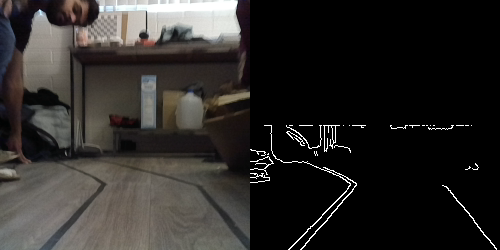

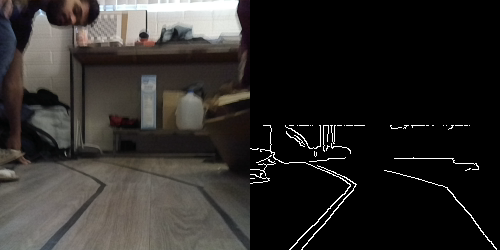

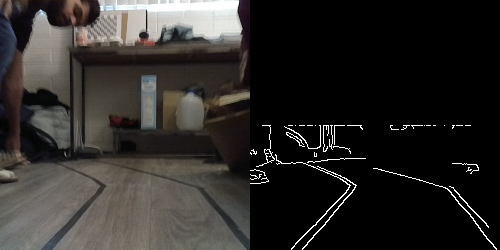

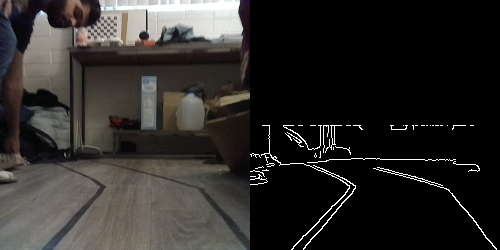

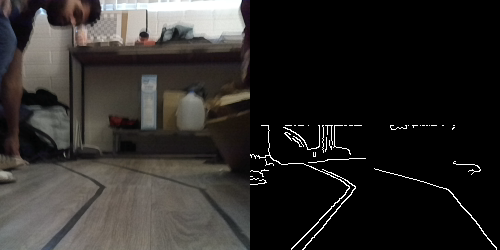

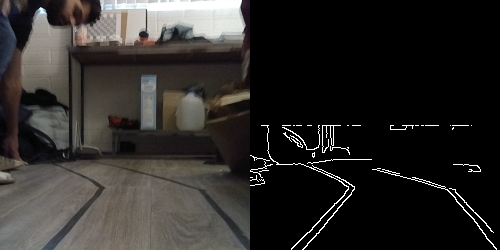

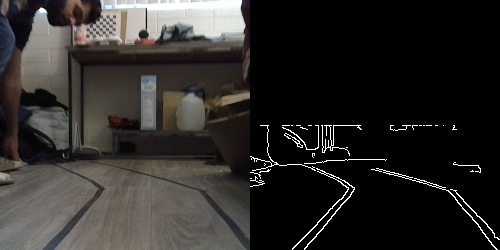

In [45]:
# Loop over the selected images
for index, row in df.head(20).iterrows():
    # Open the image file
    img = Image.open(row['image_path'])

    # Convert the image to grayscale
    gray = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)

    # Create a mask to select only the lower half of the image
    mask = np.zeros_like(gray)
    mask[int(mask.shape[0] / 2):, :] = 255

    # Apply the Canny filter to the masked image
    canny = cv2.Canny(cv2.bitwise_and(gray, gray, mask=mask), 100, 200)

    # Set the upper half of the image to black
    canny[:int(mask.shape[0] / 2), :] = 0

    # Convert the filtered image back to PIL Image
    canny_img = Image.fromarray(canny)

    # Show the original image and the filtered image side by side
    combined_img = Image.new('RGB', (img.width * 2, img.height))
    combined_img.paste(img, (0, 0))
    combined_img.paste(canny_img, (img.width, 0))
    combined_img.show()


# Build & Apply the Model

In [37]:
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from PIL import Image
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

def apply_canny_filter(img_path):
    img = Image.open(img_path)
    gray = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)
    mask = np.zeros_like(gray)
    mask[int(mask.shape[0] / 2):, :] = 255
    canny = cv2.Canny(cv2.bitwise_and(gray, gray, mask=mask), 100, 200)
    canny[:int(mask.shape[0] / 2), :] = 0
    canny_img = Image.fromarray(canny)
    return canny_img

# Load the InceptionV3 model with pre-trained weights from ImageNet
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Fine-tune the last few layers of the base model
for layer in base_model.layers[:-2]:
    layer.trainable = False

# Add custom layers to the model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(2, activation='linear')(x)

# Create the model with the custom layers
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

# Define image augmentation parameters
datagen = ImageDataGenerator(rotation_range=20,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True)

# Preprocess the image data and labels
images = []
labels = []
for index, row in df.iterrows():
    img_path = row['image_path']
    img = apply_canny_filter(img_path)
    img = img.convert("RGB")
    img = img.resize((224, 224))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = preprocess_input(img)
    images.append(img)
    label = np.array([row['linear_x'], row['angular_z']])
    labels.append(label)
    
X = np.array(images)
y = np.array(labels)

# Fit the datagen to the data and perform image augmentation
datagen.fit(X)

Epoch 1/20
6/6 [==============================] - 2s 315ms/step - loss: 0.1583 - mse: 0.1583 - val_loss: 0.1803 - val_mse: 0.1803
Epoch 2/20
6/6 [==============================] - 2s 293ms/step - loss: 0.1389 - mse: 0.1389 - val_loss: 0.1877 - val_mse: 0.1877
Epoch 3/20
6/6 [==============================] - 2s 302ms/step - loss: 0.1378 - mse: 0.1378 - val_loss: 0.1853 - val_mse: 0.1853
Epoch 4/20
6/6 [==============================] - 2s 287ms/step - loss: 0.1435 - mse: 0.1435 - val_loss: 0.1681 - val_mse: 0.1681
Epoch 5/20
6/6 [==============================] - 2s 299ms/step - loss: 0.1312 - mse: 0.1312 - val_loss: 0.1712 - val_mse: 0.1712
Epoch 6/20
6/6 [==============================] - 3s 566ms/step - loss: 0.1432 - mse: 0.1432 - val_loss: 0.1808 - val_mse: 0.1808
Epoch 7/20
6/6 [==============================] - 2s 317ms/step - loss: 0.1492 - mse: 0.1492 - val_loss: 0.1768 - val_mse: 0.1768
Epoch 8/20
6/6 [==============================] - 2s 299ms/step - loss: 0.1366 - mse: 0.13

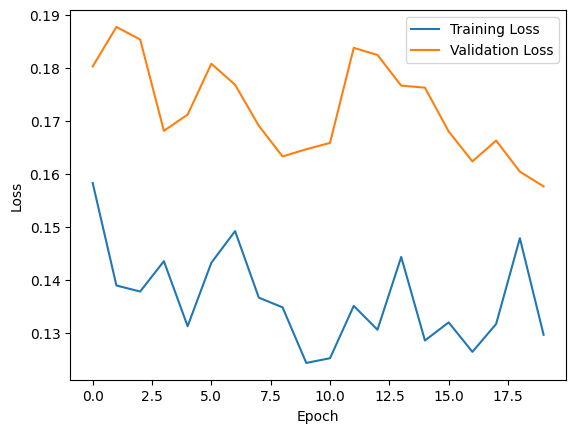

In [39]:
# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the datagen to the training data and perform image augmentation
datagen.fit(X_train)

# Train the model and save the history
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_val, y_val),
                    epochs=20)

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [40]:
# Save the model
model.save('my_model.h5')